In [9]:
# Importar librerias standard de Qiskit
from qiskit import *
from qiskit.quantum_info import Operator
from qiskit.circuit.library import *
from qiskit.visualization import *
from qiskit_ibm_runtime import *
from qiskit_aer import *

import numpy as np

service = QiskitRuntimeService(channel="local")

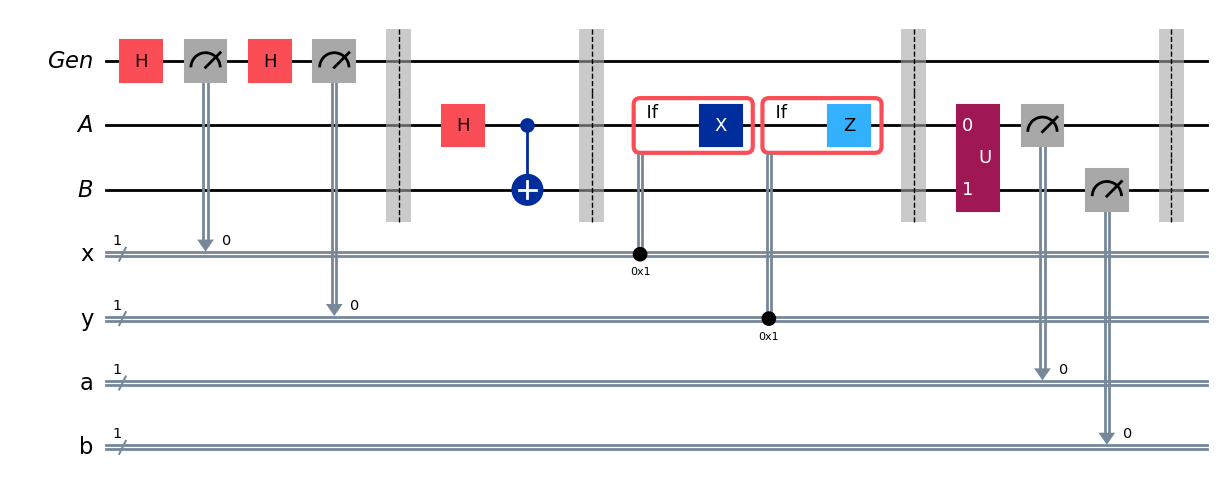

In [35]:
generator = QuantumRegister(1, "Gen")
A = QuantumRegister(1, "A")
B = QuantumRegister(1, "B")

x = ClassicalRegister(1, "x")
y = ClassicalRegister(1, "y")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(generator, A, B, x, y, a, b)

# Generar bits aleatorios x,y
protocol.h(generator)
protocol.measure(generator, x)
protocol.h(generator)
protocol.measure(generator, y)

protocol.barrier()

# Entrelazar A y B
protocol.h(A)
protocol.cx(A, B)
protocol.barrier()

# Si xy=00 -> aplcar I
# Si xy=01 -> aplicar X
# Si xy=10 -> aplicar Z
# Si xy=11 -> aplicar XZ
with protocol.if_test((x, 1)):
        protocol.x(A)

with protocol.if_test((y, 1)):
        protocol.z(A)

protocol.barrier()

# Bob mide A y B con la base B={|Φ+>, |Ψ+>, |Φ->, |Ψ->}
basis = (1/np.sqrt(2)) * np.array([
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [0, 1, 0, -1],
    [1, 0, -1, 0]
])
U = Operator(basis.transpose())
protocol.unitary(U, [A, B], label="U")

protocol.measure(A, a)
protocol.measure(B, b)

protocol.barrier()
protocol.draw(output="mpl")

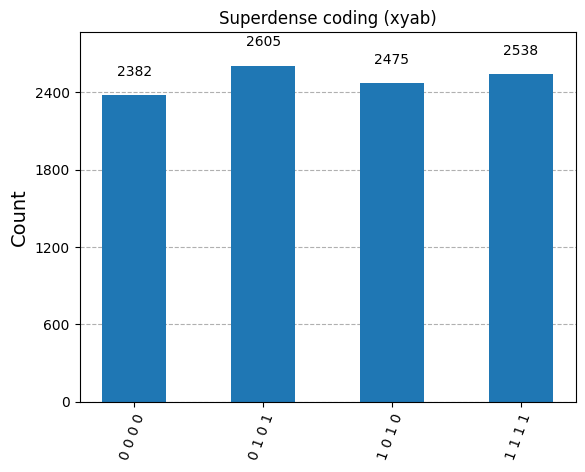

In [36]:
# Transpile for simulator
simulator = AerSimulator()
circuit = transpile(protocol, simulator)

# Run and get counts
SHOTS = 10000
result = simulator.run(circuit,shots=SHOTS).result()
counts = result.get_counts()
plot_histogram(counts, title='Superdense coding (xyab)')

In [37]:
winners = 0
for outcome, frecuency in counts.items():
    bits = outcome.replace(' ', '')
    x_bit = int(bits[0])
    y_bit = int(bits[1])
    a_bit = int(bits[2])
    b_bit = int(bits[3])

    if (x_bit == a_bit and y_bit == b_bit): winners += frecuency

print(str((winners/SHOTS) *100) + "%")

100.0%
